In [ ]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models.detection import (
    ssdlite320_mobilenet_v3_large,
    SSDLite320_MobileNet_V3_Large_Weights,
    ssd300_vgg16,
    SSD300_VGG16_Weights
)
from torchvision.transforms import v2
import pathlib
from pathlib import Path

from data import voc, coco

import CarImageClass

from SSD_from_scratch import mySSD

device = "cuda" if torch.cuda.is_available() else "cpu"

# desktop or laptop
machine = 'desktop'

# Setup path to data folder
if machine == 'laptop':
    folder_path = Path(r"C:\self-driving-car\data")
else:
    folder_path = Path(r"D:\Udacity_car_data\data")

train_path = folder_path / "train"
test_path = folder_path / "test"
train_path_simple = folder_path / "train_simple"
test_path_simple = folder_path / "test_simple"
train_path_oo = folder_path / "train_one_obj"
test_path_oo = folder_path / "test_one_obj"

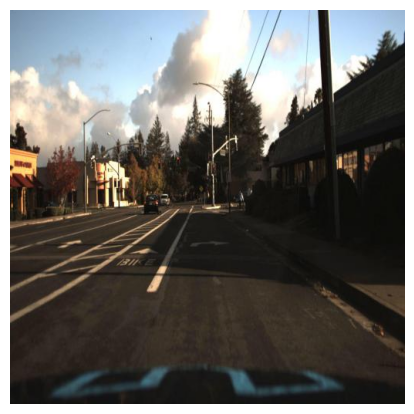

In [2]:
# transforms
train_tfms = v2.Compose([
    #v2.ToImage(),                                 # uint8 -> Tensor[C,H,W]
    #v2.ToDtype(torch.float32, scale=True),        # to float in [0,1]
    #v2.RandomHorizontalFlip(p=0.5),
    #v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((300, 300)),                        # pick a fixed size for batching
    #v2.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

train_data = CarImageClass.ImageClass(targ_dir=train_path, transform=None, file_pct=1)

train_data.show_with_box(index=53, color='r', label=False, lw=0)

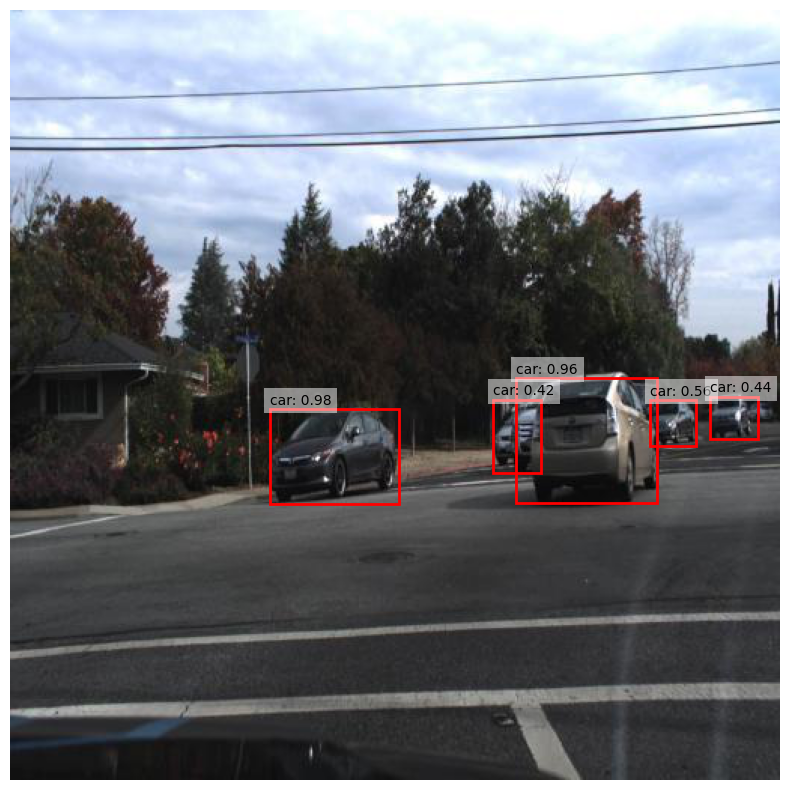

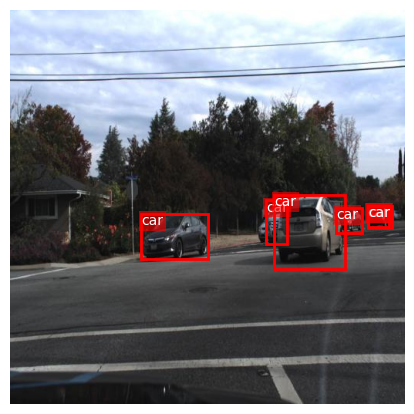

In [3]:
# 1) Device and weights
# device = torch.device("cpu")   # or "cuda" if available
weights = SSD300_VGG16_Weights.DEFAULT
categories = weights.meta["categories"]  # list of class names

# 2) Model
model = ssd300_vgg16(weights=weights).to(device).eval()

# 3) Load image
rand_idx = np.random.randint(0, len(train_data), size=1)[0]
img = train_data.load_image(rand_idx)
# img_path = np.random.choice(all_paths, size=1)[0] # r"C:\self-driving-car\data\train_one_obj\1478019978686299906_jpg.rf.bxnJeeEptGCrdAcL9zPM.jpg" #"your_image.jpg"
# img = Image.open(img_path).convert("RGB")          # keep original for plotting

# 4) Preprocess
preprocess = weights.transforms()
img_t = preprocess(img)                            # Tensor [C, 300, 300]
batch = img_t.unsqueeze(0).to(device)              # [1, C, H, W]

# 5) Inference
with torch.no_grad():
    out = model(batch)[0]                          # dict with 'boxes','labels','scores'

# 6) Pull results to CPU numpy
boxes  = out["boxes"].cpu().numpy()                # shape [N,4], xyxy in *resized* coords
labels = out["labels"].cpu().numpy()               # shape [N]
scores = out["scores"].cpu().numpy()               # shape [N]

# 7) Confidence filtering
thr = 0.25
keep = scores >= thr
boxes, labels, scores = boxes[keep], labels[keep], scores[keep]
names = [categories[i] for i in labels]

# 8) (Optional) Map boxes back to original image size
H_resized, W_resized = img_t.shape[1], img_t.shape[2]  # 300, 300
H_orig,    W_orig    = 512, 512 #img.height, img.width
sx = W_orig / W_resized
sy = H_orig / H_resized
boxes_orig = boxes.copy()
boxes_orig[:, [0,2]] *= sx
boxes_orig[:, [1,3]] *= sy

# 9) (Optional) Visualize
def draw(img_pil, boxes_xyxy, labels_txt, scores_arr):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img_pil)
    for (x1, y1, x2, y2), lbl, sc in zip(boxes_xyxy, labels_txt, scores_arr):
        ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                   fill=False, linewidth=2, edgecolor='r'))
        ax.text(x1, y1-3, f"{lbl}: {sc:.2f}", fontsize=10,
                bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"))
    ax.axis("off")
    plt.show()

draw(img, boxes_orig, names, scores)

train_data.show_with_box(index=rand_idx, color='r', label=True)

In [10]:
test_output = model(batch)

In [17]:
test_output[0]['scores']

tensor([0.9781, 0.9608, 0.5606, 0.4353, 0.4198, 0.1704, 0.1526, 0.1490, 0.1372,
        0.1238, 0.1142, 0.1113, 0.1028, 0.0993, 0.0979, 0.0970, 0.0938, 0.0923,
        0.0867, 0.0837, 0.0826, 0.0826, 0.0819, 0.0816, 0.0801, 0.0794, 0.0793,
        0.0790, 0.0779, 0.0773, 0.0768, 0.0767, 0.0760, 0.0757, 0.0750, 0.0743,
        0.0741, 0.0737, 0.0735, 0.0728, 0.0725, 0.0722, 0.0715, 0.0710, 0.0710,
        0.0710, 0.0707, 0.0700, 0.0699, 0.0698, 0.0695, 0.0693, 0.0693, 0.0691,
        0.0687, 0.0682, 0.0680, 0.0680, 0.0677, 0.0662, 0.0662, 0.0661, 0.0660,
        0.0660, 0.0658, 0.0656, 0.0655, 0.0651, 0.0646, 0.0645, 0.0642, 0.0641,
        0.0639, 0.0639, 0.0638, 0.0634, 0.0633, 0.0621, 0.0620, 0.0618, 0.0617,
        0.0614, 0.0606, 0.0604, 0.0603, 0.0599, 0.0598, 0.0594, 0.0593, 0.0590,
        0.0587, 0.0583, 0.0582, 0.0582, 0.0581, 0.0580, 0.0575, 0.0575, 0.0574,
        0.0574, 0.0570, 0.0569, 0.0565, 0.0564, 0.0564, 0.0562, 0.0562, 0.0561,
        0.0557, 0.0554, 0.0553, 0.0552, 

In [4]:
model.named_modules

<bound method Module.named_modules of SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pad

In [5]:
testmodel = mySSD(num_classes=4).to(device)

In [6]:
train_data[rand_idx][0].shape

torch.Size([3, 512, 512])

In [7]:
testmodel = mySSD(in_channels=3, num_classes=7).to(device)

# transforms
train_tfms = v2.Compose([
    #v2.ToImage(),                                 # uint8 -> Tensor[C,H,W]
    #v2.ToDtype(torch.float32, scale=True),        # to float in [0,1]
    #v2.RandomHorizontalFlip(p=0.5),
    #v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((300, 300)),                        # pick a fixed size for batching
    #v2.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

train_data = CarImageClass.ImageClass(targ_dir=train_path, transform=train_tfms, file_pct=1)
x = train_data[rand_idx][0].unsqueeze(dim=0).to(torch.float32).to(device)

testmodel.eval()  # or .train() if training
with torch.no_grad():
    output_loc, output_cls = testmodel(x)

In [8]:
output_loc

tensor([[[-0.0057,  0.0197,  0.0060, -0.0022],
         [-0.0088, -0.0039, -0.0031, -0.0137],
         [-0.0074, -0.0019, -0.0029, -0.0147],
         ...,
         [-0.0188,  0.0172,  0.0174,  0.0113],
         [-0.0135, -0.0062, -0.0038,  0.0019],
         [ 0.0038,  0.0111,  0.0079, -0.0126]]], device='cuda:0')

In [9]:
print(output_loc.shape)
print(output_cls.shape)

torch.Size([1, 8732, 4])
torch.Size([1, 8732, 7])


In [41]:
def create_default_boxes(s_min=0.2, s_max=0.9, clip=True):

    feature_map_sizes = [(38, 38), (19, 19), (10,10), (5,5), (3,3), (1,1)]
    aspect_ratios_per_level = [[2], [2,3], [2,3], [2,3], [2], [2]]

    L = len(feature_map_sizes)
    
    # scales s_0..s_{L-1}, and s_L = 1.0 for the s'_l computation
    s = [s_min + (s_max - s_min) * (l / (L - 1)) for l in range(L)]
    s.append(1.0)  # s_L

    priors = []
    for l, (H, W) in enumerate(feature_map_sizes):
        s_l  = s[l]
        s_lp = np.sqrt(s[l] * s[l+1])  # extra square

        # per-location widths/heights to emit, in (w,h), normalized
        whs = [(s_l, s_l), (s_lp, s_lp)]
        for a in aspect_ratios_per_level[l]:
            # add both a and 1/a unless a==1 (which we already handled)
            sr = np.sqrt(a)
            whs.append((s_l * sr, s_l / sr))
            whs.append((s_l / sr, s_l * sr))

        # tile over centers
        for i in range(H):
            cy = (i + 0.5) / H
            for j in range(W):
                cx = (j + 0.5) / W
                for (w, h) in whs:
                    priors.append([cx, cy, w, h])

    priors = torch.tensor(priors, dtype=torch.float32)
    if clip:
        # keep centers in [0,1], clip sizes to [eps,1]
        eps = 1e-6
        priors[:, 0:2].clamp_(0.0, 1.0)
        priors[:, 2:4].clamp_(eps, 1.0)
    return priors  # shape [num_priors, 4], (cx,cy,w,h) normalized

In [42]:
tboxes = create_default_boxes()

In [43]:
tboxes.shape

torch.Size([8732, 4])

In [44]:
tboxes[-9:-1]

tensor([[0.5000, 0.8333, 0.5374, 1.0000],
        [0.8333, 0.8333, 0.7600, 0.7600],
        [0.8333, 0.8333, 0.8270, 0.8270],
        [0.8333, 0.8333, 1.0000, 0.5374],
        [0.8333, 0.8333, 0.5374, 1.0000],
        [0.5000, 0.5000, 0.9000, 0.9000],
        [0.5000, 0.5000, 0.9487, 0.9487],
        [0.5000, 0.5000, 1.0000, 0.6364]])

In [45]:
def decode_ssd(loc, priors, variances=(0.1, 0.2)):
    """
    loc:   [num_priors, 4]  (tx, ty, tw, th)
    priors:[num_priors, 4]  (cx_a, cy_a, w_a, h_a), normalized [0,1]
    returns boxes_xyxy normalized to [0,1], shape [num_priors, 4]
    """
    v_c, v_s = variances
    # centers
    cx = loc[:, 0] * v_c * priors[:, 2] + priors[:, 0]
    cy = loc[:, 1] * v_c * priors[:, 3] + priors[:, 1]
    # sizes
    w  = priors[:, 2] * torch.exp(loc[:, 2] * v_s)
    h  = priors[:, 3] * torch.exp(loc[:, 3] * v_s)
    # to xyxy
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack([x1, y1, x2, y2], dim=1)
    return boxes

In [47]:
test_decode = decode_ssd(output_loc[0], tboxes.to(device))

In [50]:
test_decode[0]

tensor([-0.0871, -0.0864,  0.1132,  0.1135], device='cuda:0')

In [77]:
from torchvision.ops import box_iou

boxes1 = torch.tensor([[0, 0, 10, 10], [5, 5, 15, 15], [5, 6, 12, 12]], dtype=torch.float32)
boxes2 = torch.tensor([[0, 0, 10, 10], [6, 6, 12, 12]], dtype=torch.float32)

iou_matrix = box_iou(boxes1, boxes2)
print(iou_matrix)

tensor([[1.0000, 0.1333],
        [0.1429, 0.3600],
        [0.1639, 0.8571]])


In [78]:
best_prior_per_gt = iou_matrix.argmax(dim=0)           # [G]

best_prior_per_gt

tensor([0, 2])

In [79]:
iou_matrix[best_prior_per_gt, torch.arange(2)] = 2.0   # ensure > any threshold

In [80]:
iou_matrix

tensor([[2.0000, 0.1333],
        [0.1429, 0.3600],
        [0.1639, 2.0000]])

In [81]:
best_gt_per_prior = iou_matrix.argmax(dim=1)           # [P]
best_iou_per_prior = iou_matrix.gather(1, best_gt_per_prior.unsqueeze(1)).squeeze(1)

print(best_gt_per_prior)
print(best_iou_per_prior)

tensor([0, 1, 1])
tensor([2.0000, 0.3600, 2.0000])


In [82]:
pos_mask = best_iou_per_prior >= 0.5
matched_gt_xyxy = boxes2[best_gt_per_prior]   # [P,4]


print(pos_mask)
print(matched_gt_xyxy)

tensor([ True, False,  True])
tensor([[ 0.,  0., 10., 10.],
        [ 6.,  6., 12., 12.],
        [ 6.,  6., 12., 12.]])


In [76]:
matched_gt_xyxy.shape

torch.Size([2, 4])